Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.regularizers import l2

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("data/Train")
data_dir_test = pathlib.Path('data/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Loading the Train dataset, Using seed=123, resizing the images to 180x180 size
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Loading the Validation dataset, Using seed=123, resizing the images to 180x180 size
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Verifying the classes of skin cancer 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualizing one instance of all the nine classes present in the dataset

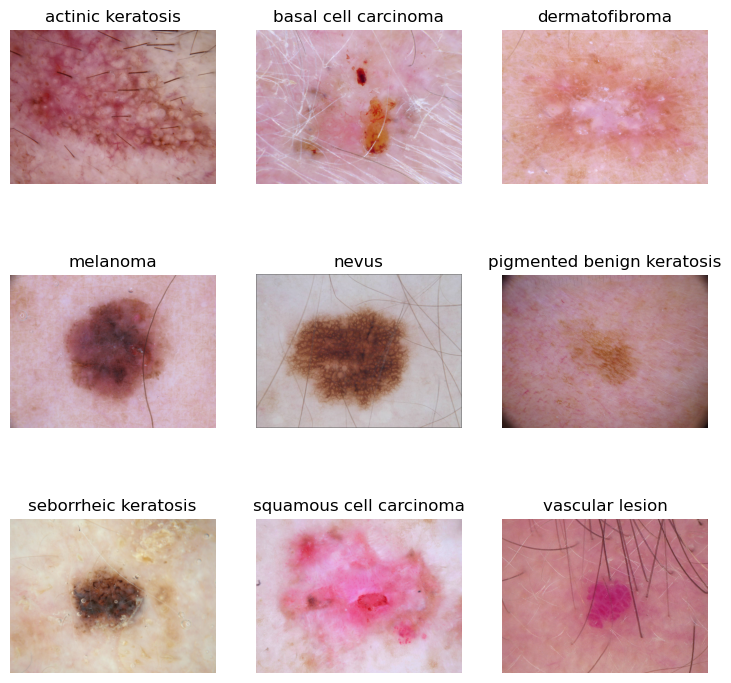

In [9]:
plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[i])
    plt.axis("off")
    imagepath = glob(os.path.join(data_dir_train, class_names[i], '*.jpg'))[0]
    image = PIL.Image.open(imagepath)
    plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the First model

In [11]:
# Defining the parameters
batch_size = 32
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

In [12]:
# Creating the Model with layers of Convolution, MaxPooling, Fully Connected
# Applying Rescaling at the input
# The output layers uses softmax to determine the different classes of skin cancer
model1 = Sequential()
model1.add(Input(shape=input_shape))
model1.add(Rescaling(1./255))
model1.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
# Choosing sgd as optimiser and categorical crossentropy loss function
model1.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20

In [16]:
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.1784 - loss: 2.1153 - val_accuracy: 0.1499 - val_loss: 2.0323
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.1753 - loss: 2.0534 - val_accuracy: 0.1924 - val_loss: 2.0231
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.2253 - loss: 2.0149 - val_accuracy: 0.1924 - val_loss: 2.0129
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2454 - loss: 2.0011 - val_accuracy: 0.3289 - val_loss: 1.9929
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.2599 - loss: 2.0000 - val_accuracy: 0.2260 - val_loss: 1.9992
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2581 - loss: 1.9851 - val_accuracy: 0.1924 - val_loss: 2.0032
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.2760 - loss: 1.9348 - val_accuracy: 0.3915 - val_loss: 1.8893
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.2984 - loss: 1.9327 - val_accuracy: 0.3490 - 

### Visualizing training results

In [17]:
# Defining a helper function to plot the results of the model execution
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

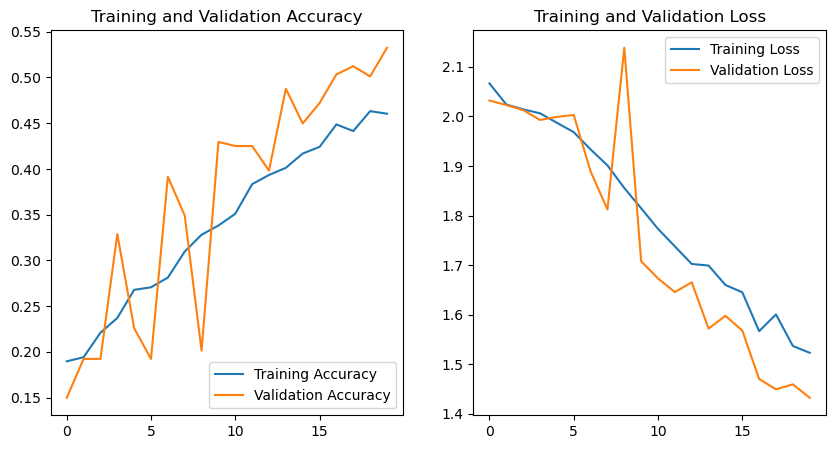

In [18]:
# Verifying the results of model training
plot_results(history1)

#### Observations from the results of this model
#### - Training Accuracy ~45%, Validation Accuracy ~50%
#### - There is a significant underfitting in this model. The training accuracy is very low and there is large variation in validation accuracies as well

In [20]:
# Defining a data augmentation layer using multiple layers of strategies
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2, seed=42)
])

In [21]:
one_batch = train_ds.take(1)

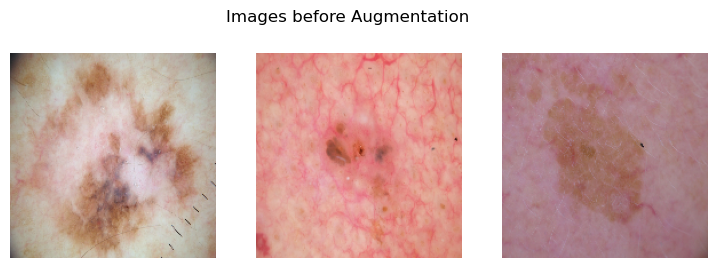

In [22]:
# Printing images before applying augmentation strategy
orig_images = [None]*3
fig = plt.figure(figsize=(9, 3))
fig.suptitle("Images before Augmentation")
for images, labels in one_batch:
  for i in range(3):
    ax1 = plt.subplot(1, 3, i + 1)
    orig_images[i] = images[i]
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

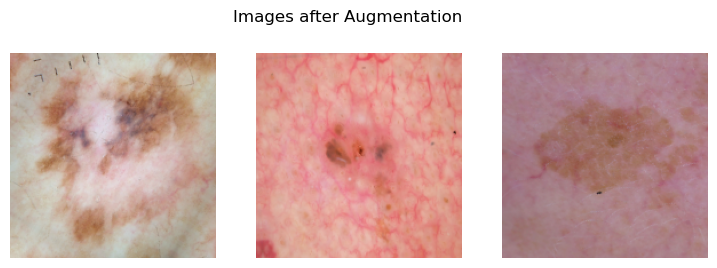

In [23]:
# Printing images after applying augmentation strategy
fig = plt.figure(figsize=(9, 3))
fig.suptitle("Images after Augmentation")
for i in range(len(orig_images)):
    ax1 = plt.subplot(1, 3, i + 1)
    aug_image = data_augmentation(orig_images[i])
    plt.imshow(aug_image.numpy().astype('uint8'))
    plt.axis("off")
plt.show()

### Creating the model including Data Augmentation


In [24]:
data_augmentation_layer = tf.keras.Sequential([
  layers.Input(shape=input_shape),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2, seed=42)
])

In [25]:
# Creating the Model with layers of Convolution, MaxPooling, Fully Connected
# Applying Rescaling at the input
# Adding the Data Augmentation layer
# Using Dropout layers as well

model2 = Sequential()
model2.add(data_augmentation_layer)
model2.add(Rescaling(1./255))
model2.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(num_classes, activation='softmax'))

### Compiling the model

In [26]:
# Choosing sgd as optimiser and categorical crossentropy loss function
model2.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [28]:
epochs=20

In [29]:
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.1917 - loss: 2.1249 - val_accuracy: 0.2931 - val_loss: 2.0850
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.2175 - loss: 2.0411 - val_accuracy: 0.2192 - val_loss: 2.0702
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.2140 - loss: 2.0216 - val_accuracy: 0.2640 - val_loss: 2.0878
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.2546 - loss: 1.9762 - val_accuracy: 0.3557 - val_loss: 2.0493
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.2878 - loss: 1.9640 - val_accuracy: 0.3110 - val_loss: 2.0602
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.2812 - loss: 1.9652 - val_accuracy: 0.2573 - val_loss: 2.0237
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.2781 - loss: 1.9461 - val_accuracy: 0.3020 - val_loss: 1.9962
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.2805 - loss: 1.9285 - val_accuracy: 0.259

### Visualizing the results

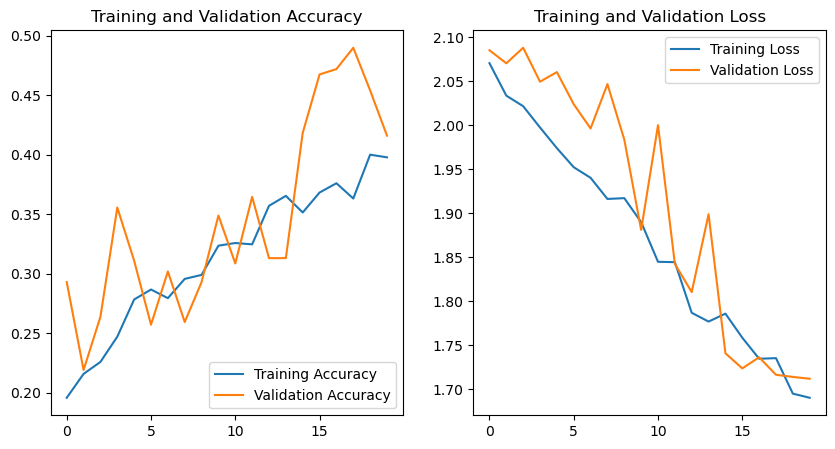

In [30]:
plot_results(history2)

#### Observations from the results of this model
#### - Training Accuracy ~40%, Validation Accuracy ~45%
#### - There is a still significant underfitting in this model. 

#### Verifying the distribution of classes in the training dataset.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [32]:
# Fetch all images
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list[:3]

['data\\Train\\actinic keratosis\\ISIC_0025780.jpg',
 'data\\Train\\actinic keratosis\\ISIC_0025803.jpg',
 'data\\Train\\actinic keratosis\\ISIC_0025825.jpg']

In [33]:
# Fetch class of each image
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list[:3]

['actinic keratosis', 'actinic keratosis', 'actinic keratosis']

In [34]:
# Create a dictionary mapping the images to the corresponding class/folder path
imageclass_dict = dict(zip(path_list, lesion_list))

In [35]:
imageclass_df = pd.DataFrame(list(imageclass_dict.items()),columns = ['Path','Label'])

In [36]:
# Verify the counts for each class label
imageclass_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<Axes: >

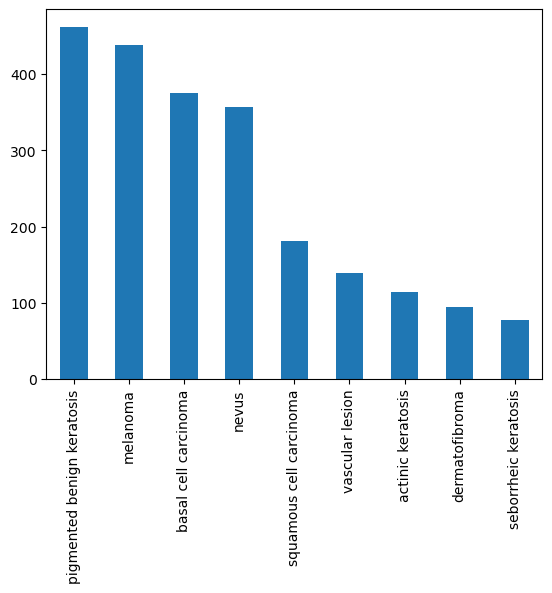

In [37]:
# Verify the number of images for each class
imageclass_df['Label'].value_counts().plot.bar()

#### Observations from the training dataset: 
#### - Class 'seborrheic keratosis' has the least number of samples
#### - Classes 'pigmented benign keratosis', 'melanoma' dominate the data in terms number of samples


### Taking measures to rectify the class imbalance
#### Using Augmentor to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset=str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to data\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17D412B53D0>: 100%|█████████████████████████████████████████| 500/500 [00:01<00:00, 300.44 Samples/s]


Initialised with 376 image(s) found.
Output directory set to data\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17D2B968190>: 100%|█████████████████████████████████████████| 500/500 [00:01<00:00, 296.52 Samples/s]


Initialised with 95 image(s) found.
Output directory set to data\Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17D4135A550>: 100%|███████████████████████| 500/500 [00:01<00:00, 290.88 Samples/s]


Initialised with 438 image(s) found.
Output directory set to data\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17D41202A50>: 100%|█████████████████████████████████████████| 500/500 [00:09<00:00, 52.55 Samples/s]


Initialised with 357 image(s) found.
Output directory set to data\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x17D2B85F850>: 100%|████████████████████████████████████████| 500/500 [00:08<00:00, 56.03 Samples/s]


Initialised with 462 image(s) found.
Output directory set to data\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17D2B849090>: 100%|█████████████████████████████████████████| 500/500 [00:01<00:00, 266.79 Samples/s]


Initialised with 77 image(s) found.
Output directory set to data\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17D2B84FF90>: 100%|████████████████████████████████████████| 500/500 [00:03<00:00, 125.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to data\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17D2B86CA50>: 100%|█████████████████████████████████████████| 500/500 [00:02<00:00, 248.62 Samples/s]


Initialised with 139 image(s) found.
Output directory set to data\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17D2B95EDD0>: 100%|███████████████████████| 500/500 [00:01<00:00, 270.53 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Verifying the distribution of augmented data after adding new images to the original training data.

In [41]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:3]

['data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_32159eaf-b681-4a8b-8ef9-36b0792ade97.jpg',
 'data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_332946dd-1ccd-44cd-8ff5-b257780fc8e6.jpg',
 'data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_5ace7f89-3255-430c-a1d2-62e236fe8d99.jpg']

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:3]

['actinic keratosis', 'actinic keratosis', 'actinic keratosis']

In [43]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
newimageclass_df = pd.concat([imageclass_df, df2])

In [45]:
newimageclass_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [46]:
# Creating training dataset from the augmented data
new_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [47]:
# Creating validation dataset from the augmented data
new_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
new_train_ds = new_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
new_val_ds = new_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Creating the new Model

In [49]:
# Creating the Model with layers of Convolution, MaxPooling, Fully Connected
# Applying Rescaling at the input
# Adding Normalizing and Dropout as well
# The output layers uses softmax to determine the different classes of skin cancer

model3 = Sequential()
model3.add(Input(shape=input_shape))
model3.add(Rescaling(1./255))
model3.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(num_classes, activation='softmax'))

In [50]:
model3.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,990,249 (15.22 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

#### Training the model on the new augmented dataset

In [52]:
epochs = 30

In [53]:
history3 = model3.fit(
  new_train_ds,
  validation_data=new_val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.2415 - loss: 3.0359 - val_accuracy: 0.1084 - val_loss: 7.7651
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 194ms/step - accuracy: 0.4202 - loss: 1.5349 - val_accuracy: 0.1938 - val_loss: 5.1341
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.4843 - loss: 1.3403 - val_accuracy: 0.3022 - val_loss: 3.2031
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.5465 - loss: 1.1614 - val_accuracy: 0.1863 - val_loss: 4.8527
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.6151 - loss: 1.0252 - val_accuracy: 0.4863 - val_loss: 1.9000
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.6558 - loss: 0.9105 - val_accuracy: 0.4499 - val_loss: 2.0403
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 200ms/step - accuracy: 0.6858 - loss: 0.8245 - val_accuracy: 0.5961 - val_loss: 1.3087
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.7332 - loss: 0

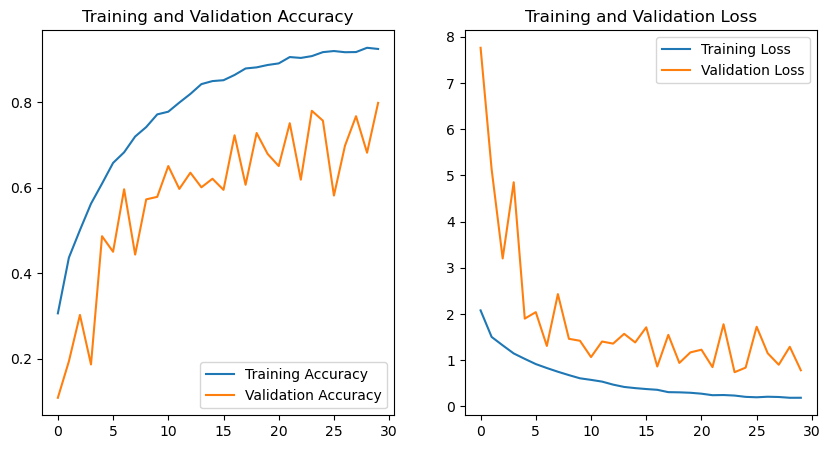

In [54]:
# Verifying the results of model training
plot_results(history3)

#### Observations from the results of this model
#### - Training Accuracy ~92%, Validation Accuracy ~79%
#### - There is a significant improvement in the model after handling class imbalance. 
#### - Both training and validation accuracy have improved and look good with this model.